In [1]:
import numpy as np 
import math
import pandas as pd 
from pathlib import Path
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut, cross_val_score

In [2]:
# load all datasets
def load_created_datasets():
    data_list = []
    DATA_PATH = Path('./data/created/')
    
    file_paths = DATA_PATH.glob('*.csv')
    for file_path in file_paths:
        df = pd.read_csv(file_path, index_col='Country')
        data_list.append(df)
    return pd.concat(data_list, join='inner', axis=1)
complete_data = load_created_datasets()

In [3]:
rf_data = complete_data.copy()
rf_data.shape

(42, 43)

## Random Forest Regression
We perform random forest regression here to predict the outcome of our relative threatened species for all groups combined and for each group separately, as well as the trends. As a random forest is a tree partitioning algorithm it does by nature not need any scaling of the data beforehand. After the results of our correlation analysis we start with the full model here.
As the number of samples in our remaining data frame is quite limited, we use leave one out cross validation to measure the performance of our regressor rather than a train/test split.Because of the high dimension of the data, we take the square root of the total number of features to pick for every split.

In [4]:
def extract_from_cv_results(cv_results, row_name=None):
    cv_results = pd.DataFrame(cv_results)
    best_scores = {}
    best_params = {}

    scores = [col.replace('mean_test_', '') for col in cv_results.columns if col.startswith('mean_test_')]
    params = [col for col in cv_results.columns if col.startswith('param_')]

    for score in scores:
        best_params[score] = {}
        # rank is 1 for multiple models if score is equal
        best_model_by_score = cv_results[cv_results[f'rank_test_{score}'] == 1].iloc[0]
        best_scores[f'mean_{score}'] = best_model_by_score[f'mean_test_{score}']
        best_scores[f'std_{score}'] = best_model_by_score[f'std_test_{score}']
        for param in params:
            p = param.split('__')[-1]
            best_params[score][p] = best_model_by_score[param]
    
    best_params = pd.DataFrame(best_params)
    if row_name is None:
        best_scores = pd.DataFrame(best_scores, index=['value'])
    else:
        best_scores = pd.DataFrame(best_scores, index=[row_name])
        best_params['target'] = row_name
        best_params = best_params.reset_index().set_index(['target', 'index'])
    return best_scores, best_params

In [5]:
def results_by_target(data, cv_results_by_target):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    best_scores = []
    best_params = []
    for target in target_columns:
        scores, params = extract_from_cv_results(cv_results_by_target[target], target)
        best_scores.append(scores)
        best_params.append(params)

    best_scores = pd.concat(best_scores)
    best_scores = best_scores.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'std_neg_root_mean_squared_error': 'RMSE_var',
        'mean_neg_mean_absolute_error': 'MAE',
        'std_neg_mean_absolute_error': 'MAE_var'
    })
    best_scores[['RMSE', 'MAE']] = best_scores[['RMSE', 'MAE']].apply(lambda x: -x)
    best_scores[['RMSE_var', 'MAE_var']] = best_scores[['RMSE_var', 'MAE_var']].apply(lambda x: x**2)

    best_params = pd.concat(best_params)
    best_params = best_params.rename(columns={
        'mean_neg_root_mean_squared_error': 'RMSE',
        'mean_neg_mean_absolute_error': 'MAE',
    })

    return best_scores, best_params

In [6]:
def rf_predict_threatened_relative(data):
    cv_results = {}

    # iterate all target variables
    columns_threatened = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    for target in columns_threatened:
        y = data[target]
        X = data.drop(columns=columns_threatened)


        # n_estimator(number of trees) is the hyperparameter that we try to optimize here
        n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
        grid = random_grid = {'n_estimators': n_estimators}
        rf=RandomForestRegressor(max_features = 'sqrt', random_state=0)
        rf_grid = GridSearchCV(estimator = rf, param_grid = random_grid,  cv = LeaveOneOut(),  scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error'],
            refit='neg_root_mean_squared_error')
        rf_grid.fit(X,y)    
        cv_results[target] = rf_grid.cv_results_

    return cv_results
rf_cv_results = rf_predict_threatened_relative(complete_data)

In [8]:
rf_best_scores, rf_best_params = results_by_target(complete_data, rf_cv_results)

In [11]:
rf_best_scores

,RMSE,RMSE_var,MAE,MAE_var
total_threatened,0.036184,0.001551,0.036184,0.001551
mammals_threatened,0.044248,0.001707,0.044248,0.001707
insects_threatened,0.039302,0.001690,0.039302,0.001690
amphibians_threatened,0.112733,0.013013,0.112733,0.013013
birds_threatened,0.021253,0.001193,0.021253,0.001193
reptiles_threatened,0.086855,0.010020,0.086855,0.010020
decreasing_trend,0.025011,0.000522,0.025011,0.000522
increasing_trend,0.028355,0.000467,0.028355,0.000467
stable_trend,0.038317,0.001841,0.038317,0.001841


In [16]:
rf_data

,temp_slope,gain_percentage,temp_difference,Unnamed: 0,CH4,CO2,HFC,N2O,NF3,PFC,...,birds_threatened,reptiles_threatened,mammals_resident,insects_resident,amphibians_resident,birds_resident,reptiles_resident,decreasing_trend,increasing_trend,stable_trend
Country,,,,,,,,,,,,,,,,,,,,,
Argentina,0.014949,0.500525,0.072246,0,1.828861,4.710241,0.014370,1.002114,-1.000000,0.003744,...,0.0519,0.0771,True,True,True,True,True,0.274619,0.043458,0.396209
Australia,0.017804,0.969423,0.214683,1,4.382540,16.642911,0.479420,0.804808,-1.000000,0.009443,...,0.0716,0.0766,True,True,True,True,True,0.195591,0.029391,0.407978
Austria,0.038525,24.241043,1.498389,2,0.728541,7.549433,0.207606,0.398982,0.001868,0.003680,...,0.0426,0.0769,True,True,True,True,True,0.342246,0.108289,0.295455
Belgium,0.028670,12.044550,1.167659,3,0.688260,8.787278,0.391962,0.500037,0.000057,0.011516,...,0.0303,0.0000,True,True,True,True,True,0.332008,0.145129,0.298211
Brazil,0.033281,3.703937,0.929317,4,1.683181,2.566549,-1.000000,0.894033,-1.000000,-1.000000,...,0.0914,0.0766,True,True,True,True,True,0.315529,0.028848,0.291864
Canada,0.037969,-24.178355,1.583367,5,2.466998,15.826302,0.338527,1.023899,0.000003,0.016758,...,0.0426,0.1429,True,True,True,True,True,0.232601,0.158425,0.479853
Chile,0.014697,9.319080,0.761799,6,0.767192,4.837817,0.157948,0.369279,-1.000000,0.000000,...,0.0774,0.2295,True,True,True,True,True,0.302956,0.070197,0.407635
Colombia,0.020083,3.383376,0.833692,8,0.946694,1.691487,0.039670,0.478937,-1.000000,-1.000000,...,0.0637,0.0837,True,True,True,True,True,0.372725,0.035376,0.329915
Costa Rica,0.018108,2.447034,0.604383,9,0.820945,1.651245,0.125102,0.224534,-1.000000,-1.000000,...,0.0328,0.0558,True,True,True,True,True,0.327454,0.077014,0.366255


In [13]:
def extract_cv_scores(data, cv_results, score):
    target_columns = [col for col in data.columns if col.endswith('threatened') or col.endswith('trend')]
    results_by_target = {}
    for target in target_columns:
        results = pd.DataFrame(cv_results[target])
        best_results = results[results[f'rank_test_{score}'] == 1].iloc[0]
        cv_scores = [best_results[f'split{i}_test_{score}'] for i in range(data.shape[0])]
        cv_scores = [-val for val in cv_scores]
        results_by_target[target] = cv_scores
    return pd.DataFrame(results_by_target)

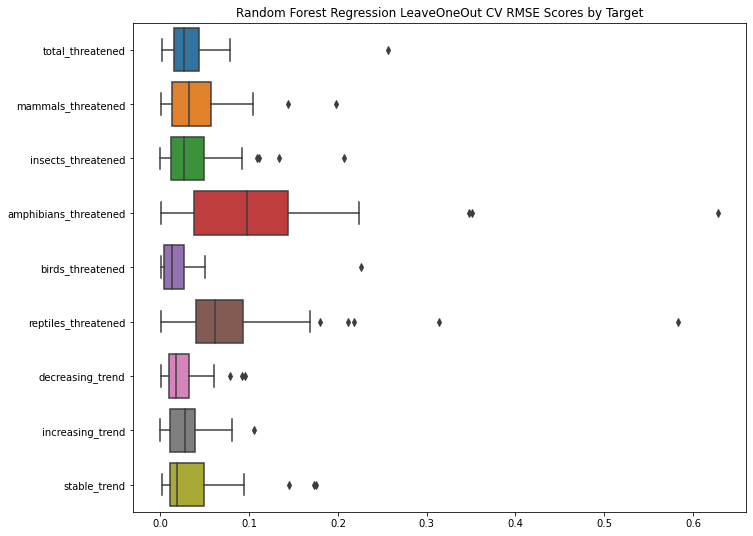

In [14]:
# get data
vis_rf_scores = extract_cv_scores(complete_data, rf_cv_results, 'neg_root_mean_squared_error')

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Random Forest Regression LeaveOneOut CV RMSE Scores by Target')

sns.boxplot(data=vis_rf_scores, orient='h')
plt.show()

## Conclusion
As performance metric we used the RMSE here. As the range of our threatened species percentage of all groups is from 1.7%-16.7%, a RMSE of 5% is a pretty big offset. For amphibians the RMSE even suggests a mean 16% offset (maximum for all targets). These values indicate rather bad predictions that suggest that our model is not very well suited to predict the percentage of threatened animals in a country.